# Recomendador de peliculas Movieslens 

This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

In [1]:
##path = "E:\\Documentos\\Master\\movies\\ml-100k\\" #Dataset de 100k usuarios
path = "/home/sergio/Descargas/ml-100k/"

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import pdist 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import pairwise_distances
%matplotlib notebook

In [69]:
df_movies = pd.read_table(path + "u.data", names = ["user_id","item_id","rating","timestamp"])
df_users = pd.read_table(path + "u.user", names = ["user_id","age","gender","occupation", "zip_code"], sep="|", index_col="user_id")

df_users.zip_code = pd.to_numeric(df_users.zip_code, errors=np.nan)
df_users = df_users.dropna()

In [70]:
mms = MinMaxScaler(feature_range=(0,100))
mms.fit(df_movies.timestamp.values.reshape(-1,1))
df_movies.timestamp = mms.transform(df_movies.timestamp)


#X_train, X_test, y_train, y_test = train_test_split(df_movies.loc[:,["user_id","rating","timestamp"]], df_movies.loc[:,["item_id"]], test_size=0.33, random_state=42)
X_train, X_test = train_test_split(df_movies, test_size=0.33, random_state=42)




/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Vamos a dummificar las variables

In [4]:
df_users2 = df_users
df_users2["age"].apply(lambda x: np.int(np.round(x / 10))) #Es probable que no sea necesaria.
df_users2 = pd.concat([df_users,pd.get_dummies(df_users.gender), pd.get_dummies(df_users.occupation)], axis = 1) #gender y occu
df_users2 = df_users2.drop(["gender","occupation"], axis = 1) #Borramos las columnas


# Escalamos el codigo postal (Los estados proximos entre si tienen numeros cercanos)
min_max_scaler = MinMaxScaler()
df_users2["zip_code"] = min_max_scaler.fit_transform(df_users2.zip_code.reshape(-1,1))

users_dist = pdist(df_users2, metric='cosine') #Calculamos la matriz de distancias.
users_diste = pdist(df_users2, metric='euclidean')
df_users2.head()

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


,age,zip_code,F,M,administrator,artist,doctor,educator,engineer,entertainment,...,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
user_id,,,,,,,,,,,,,,,,,,,,,
1,24,0.858527,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,53,0.941984,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,23,0.321200,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,24,0.436090,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,33,0.152381,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>


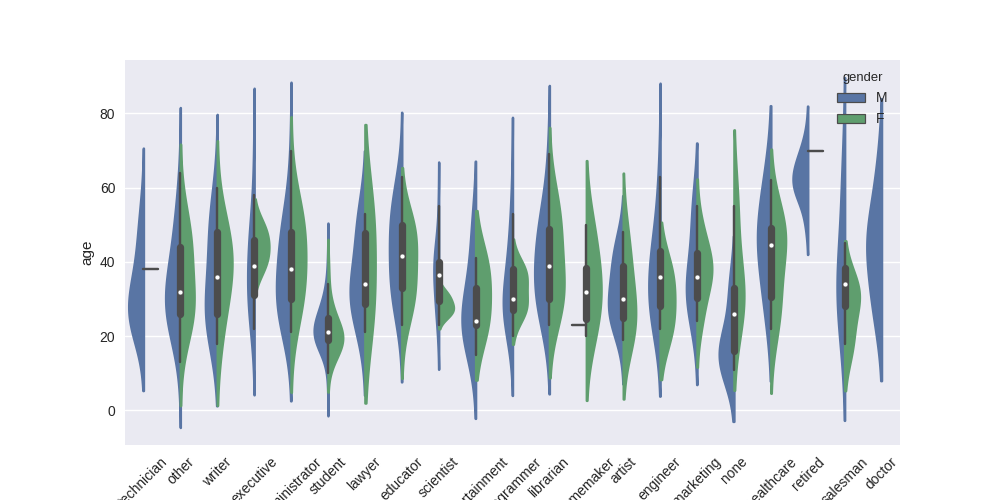

In [7]:
%matplotlib notebook
plt.figure(figsize=(10,5), dpi=100)
sns.violinplot(x="occupation", y="age", hue="gender", data=df_users, split=True, bw=0.8)
plt.xticks(rotation=45);

<IPython.core.display.Javascript object>


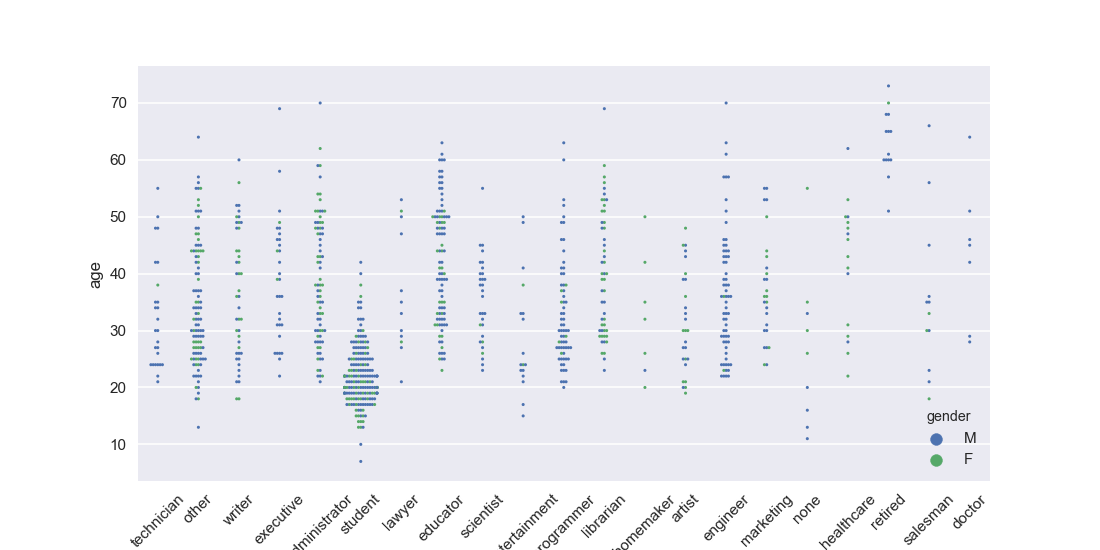

In [2]:
%matplotlib notebook
plt.figure(figsize=(10,5), dpi=100)
sns.swarmplot(x="occupation", y="age", hue="gender", data=df_users, size=2)
plt.xticks(rotation=45);

In [66]:
# Descomposición de la matriz de usuarios


svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd.fit(df_users2)
df_users2t = pd.DataFrame(svd.transform(df_users2))
users_dist2t = pdist(df_users2t, metric='cosine')
users_dist2te = pdist(df_users2t, metric='euclidean')

In [67]:
#Matriz de peliculas vistas

df_movies_vistas = df_movies.pivot_table(index= "user_id", columns = "item_id", aggfunc= "count", values="rating", fill_value=0)
df_movies_vistas_freq = df_movies_vistas.div(np.sum(df_movies_vistas, axis = 1), axis=0).fillna(0)
df_movies_vistas_freq.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.003676,0.003676,0.003676,0.003676,0.003676,0.003676,0.003676,0.003676,0.003676,0.003676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.005714,0.005714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


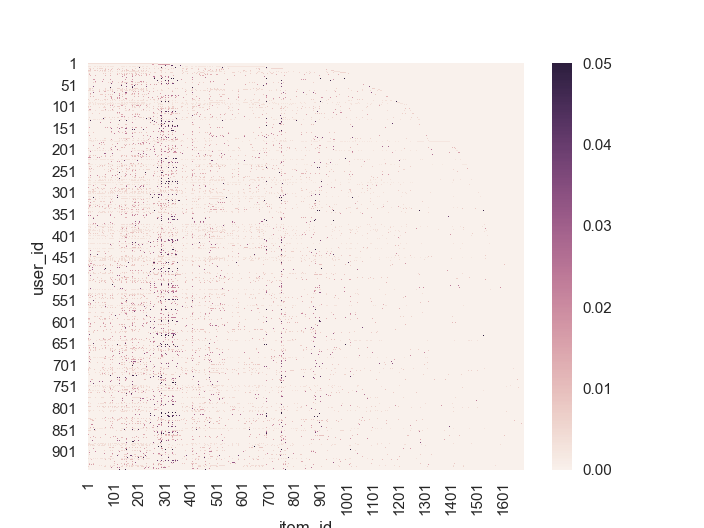

In [52]:
%matplotlib notebook
plt.figure()
sns.heatmap(df_movies_vistas_freq, xticklabels=100, yticklabels=50)
plt.xticks(rotation = 90);
plt.yticks(rotation = 0);

<IPython.core.display.Javascript object>


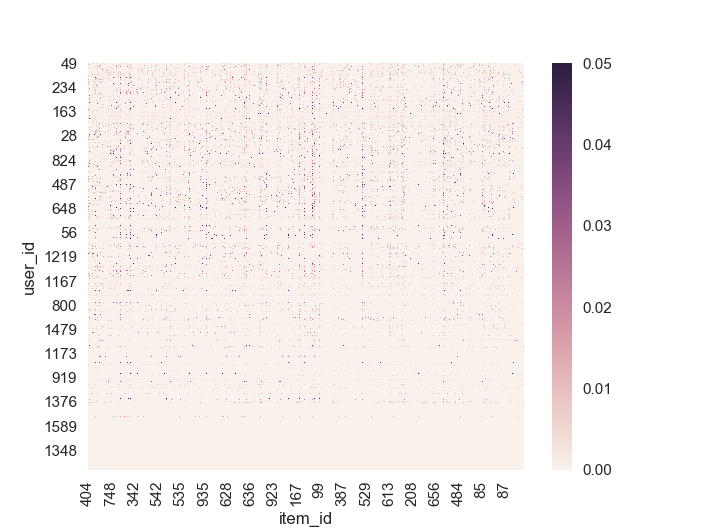

In [51]:
%matplotlib notebook
plt.figure()
sns.heatmap(df_movies_vistas_freq.loc[np.sum(df_movies_vistas, axis = 0).argsort()[::-1],np.sum(df_movies_vistas, axis = 1).argsort()[::-1]].fillna(0), xticklabels=50, yticklabels=100)
plt.xticks(rotation = 90);
plt.yticks(rotation = 0);
plt.show()

In [72]:
X_train_mat = X_train.pivot(index="item_id", columns="user_id", values="rating").fillna(0)
X_test_mat = X_test.pivot(index="item_id", columns="user_id", values="rating").fillna(0)

X_train_mat = X_train_mat.as_matrix()
X_test_mat = X_test_mat.as_matrix()

user_similarity = pairwise_distances(X_train_mat, metric='cosine')
item_similarity = pairwise_distances(X_train_mat.T, metric='cosine')
user_similarity_euclidean = pairwise_distances(X_train_mat, metric='euclidean', )
item_similarity_euclidean = pairwise_distances(X_train_mat.T, metric='euclidean')

<IPython.core.display.Javascript object>


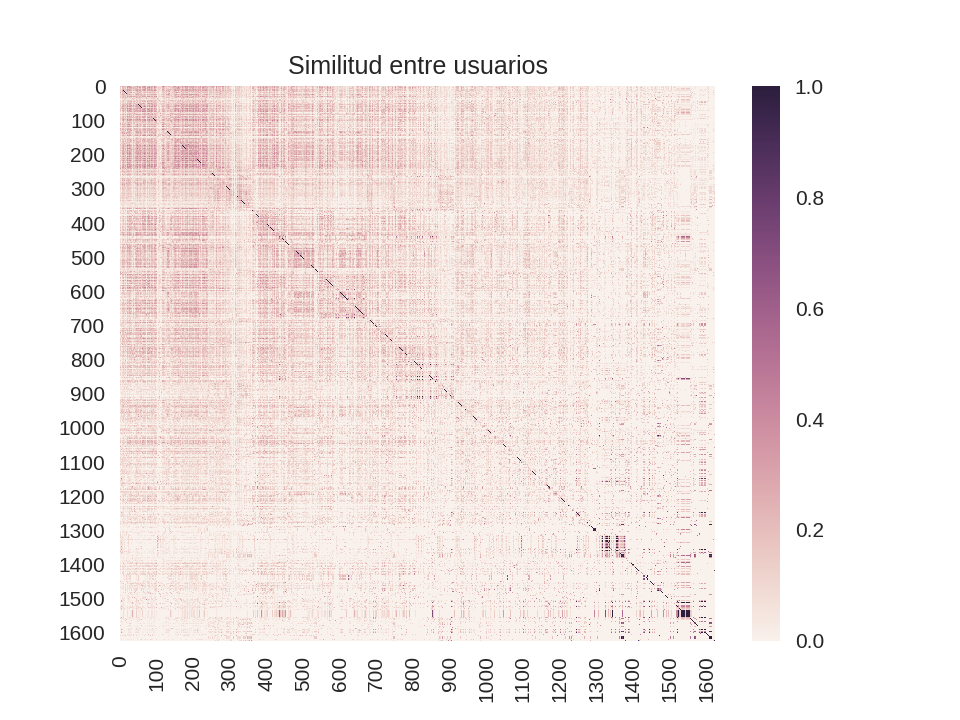

<IPython.core.display.Javascript object>


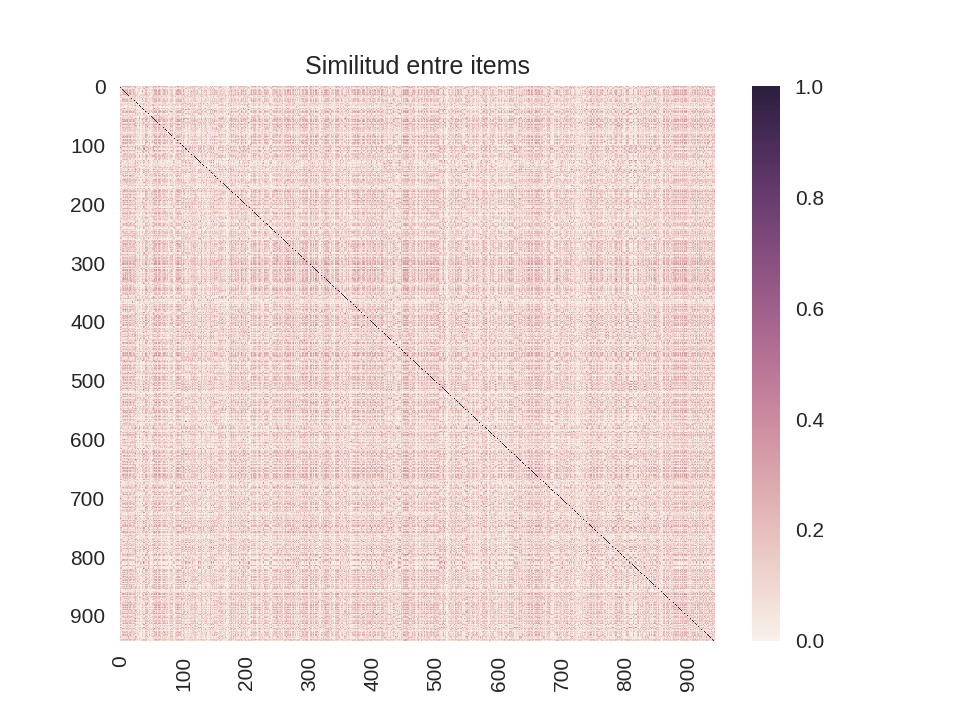

In [78]:
plt.figure(dpi=150)
sns.heatmap(1-user_similarity, xticklabels=100, yticklabels=100)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.title("Similitud entre usuarios")
plt.show()

plt.figure(dpi=150)
sns.heatmap(1-item_similarity, xticklabels=100, yticklabels=100)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.title("Similitud entre items")
plt.show()

In [75]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [90]:
item_prediction = predict(X_train_mat, item_similarity, type='item')
user_prediction = predict(X_train_mat, user_similarity, type='user')

from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))


print('User-based CF RMSE: ' + str(rmse(user_prediction, X_test_mat)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, X_test_mat)))

User-based CF RMSE: 3.28878899511088
Item-based CF RMSE: 3.4161067012443005


In [84]:
item_prediction = predict(X_train_mat, item_similarity_euclidean, type='item')
user_prediction = predict(X_train_mat, user_similarity_euclidean, type='user')

from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))


print('User-based CF RMSE: ' + str(rmse(user_prediction, X_test_mat)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, X_test_mat)))

(943, 943)
(1624, 1624)
(1624, 943)


<IPython.core.display.Javascript object>


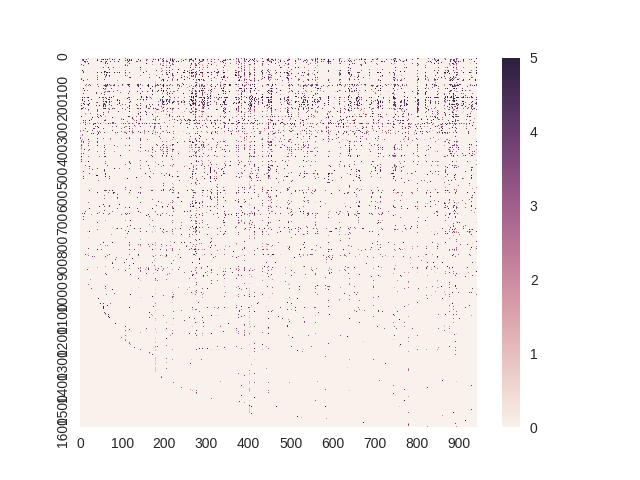

In [97]:
print(item_similarity.shape)
print(user_similarity.shape)
print(X_train_mat.shape)
sns.heatmap(X_train_mat, xticklabels=100, yticklabels=100)